# Sentiment Analysis: Amazon Reviews
***Question: Can we predict the polarity of a given review?***

In this notebook, machine learning (ML) methods are used to perform a common natural language processing (NLP) task, **sentiment analysis**. There are many types and flavors of sentiment analysis and here we focus on polarity (<span style="color:red">**positve**</span> or <span style="color:blue">**negative**</span>) of texts.


**Table of Contents**

1. [Data Introduction](#1)<br>
2. [Data Cleansing and Exploration](#2)<br>
    2.1. [Text Preprocessing](#2.1)<br>
    2.2. [WordCloud](#2.2)<br>
3. [Classification Using *sklearn*](#3)<br>
    3.1. [Features: token counts](#3.1)<br>
    3.2. [Features: tf-idf](#3.2)<br>
4. [Neural Networks](#4)<br>
    4.0. [Text Tokenization and Word Embedding](#4.0)<br>
    4.1. [ConvNet 1D](#4.1)<br>
    4.2. [RNN-LSTM](#4.2)<br>
5. [Conclusions](#5)<br>

**Main packages used**: *sklearn*, *nltk*, *keras*, *wordcloud*, *pandas*, *numpy*.

For a qucik **summary of the results** from tested methods, please jump to [Conclusions](#5).

## 1. Data Introduction<a id="1"></a>

The data was shared in [Kaggle](https://www.kaggle.com/bittlingmayer/amazonreviews) and original came from [Xiang Zhang's Google Drive dir](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). 

- The training dataset contains a few million Amazon customer reviews in the format of 

    `__label__<X> ... <Text>`

    where `__label__1` corresponds to 1- and 2-star reviews, and `__label__2` corresponds to 4- and 5-star reviews. 3-star reviews i.e. reviews with neutral sentiment were not included in the original


- Most of the reviews are in English, but there are a few in other languages, like Spanish.

- The test set contains about 400k reviews.

**Notes**
- Modeling uses Kaggle kernel with configuration of **2 CPUs + 1 GPU** and **13G RAM**. 


**Import library**

In [1]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import chardet   # The Universal Character Encoding Detector
import re
import os
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import nltk
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

## 2. Data Cleansing<a id="2"></a>

**Load the data**

In [2]:
train_file = bz2.BZ2File('../input/amazonreviews/train.ft.txt.bz2')
test_file = bz2.BZ2File('../input/amazonreviews/test.ft.txt.bz2')

In [3]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()
del train_file, test_file

### 2.1. Text Preprocessing<a id="2.1"></a>
The texts are stored in fasttext format. Decode them to UTF-8.

In [4]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]
print('Two examples of the reviews:')
print(train_file_lines[1])
print(train_file_lines[6])

Two examples of the reviews:
__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.

__label__1 Buyer beware: This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "wors

In the following two cells, we do the following processing:
- Split the texts in the training dataset into content (**train_sentences**) and labels (**train_labels**).
- Remove *number digits*, *HTML tags*, *punctuations*, and some *special characters*.
- Remove *stop words*, where stopwords from [nltk](https://www.nltk.org/) is used.

In [5]:
# helper to remove stopwords
def rm_stopwords(sentences, stop_words):
    for i, s in enumerate(sentences):
        new_s = [word for word in s.split() if word not in stop_words]
        sentences[i] = ' '.join(new_s)
    return sentences

In [6]:
stop_words = set(stopwords.words('english'))   # set is faster for 'in' operation
# '__label__1' represents negative comment, while '__label__2' represent positive comment.
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]
for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d',' ',train_sentences[i])                                                    
for i in range(len(train_sentences)):
    # remove html tags
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
    # remove Punctuations
    train_sentences[i] = re.sub(r'[?|!|\'|"|#]',r'',train_sentences[i])
    train_sentences[i] = re.sub(r'[.|,|)|(|\|/]',r' ',train_sentences[i])
    # some more special characters
    for c in ['-', '^', '$', '%', '&', '*', '@', ':']:
        train_sentences[i] = train_sentences[i].replace(c, ' ')
# remove stopwords
train_sentences = rm_stopwords(train_sentences, stop_words)


Let's now have a look at the content after cleaning.

In [7]:
print(train_sentences[1])
print('\n')
print(train_sentences[6])

best soundtrack ever anything im reading lot reviews saying best game soundtrack figured id write review disagree bit opinino yasunori mitsudas ultimate masterpiece music timeless im listening years beauty simply refuses fade price tag pretty staggering must say going buy cd much money one feel would worth every penny


buyer beware self published book want know read paragraphs star reviews must written ms haddons family friends perhaps cant imagine anyone reading whole thing spent evening book friend hysterics reading bits pieces one another definitely bad enough entered kind worst book contest cant believe amazon even sells kind thing maybe offer th grade term paper kill mockingbird book quite sure ms haddon never heard anyway unless mood send book someone joke stay far far away one


Repeat the same operations for the test dataset.

In [8]:
# repeat for test set
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]
for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d',' ',test_sentences[i])                                                    
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])
    test_sentences[i] = re.sub(r'[?|!|\'|"|#]',r'',test_sentences[i])
    test_sentences[i] = re.sub(r'[.|,|)|(|\|/]',r' ',test_sentences[i])
    for c in ['-', '^', '$', '%', '&', '*', '@', ':']:
        test_sentences[i] = test_sentences[i].replace(c, ' ')
# remove stopwords
test_sentences = rm_stopwords(test_sentences, stop_words)

In [9]:
print("The training set has {} samples.".format(len(train_labels)))
print("In the training datset, there are {} postive reviews out of {} samples.".format(sum(train_labels), len(train_labels)))
print("The test set has {} samples.".format(len(test_labels)))

The training set has 3600000 samples.
In the training datset, there are 1800000 postive reviews out of 3600000 samples.
The test set has 400000 samples.


Clearly, the training dataset has 3.6M reviews and half are postive, half are negative, which is good because we have a **balanced dataset**. In the test dataset, we have 40k reviews.

In [10]:
del train_file_lines, test_file_lines
gc.collect()

18

### 2.2. WordCloud<a id="2.2"></a>
WordCloud is a novelty visual represenation of text data with the importance of each word shown with font size. It has been frequently used as art designs.

For our texts, we have two types of polarities, so it would be informative to plot them separately. For fun, we will use different masks for each type: a "<span style="color:red">**thumb up**</span>" shape for the <span style="color:red">**positve**</span> reviews and a "<span style="color:blue">**thumb down**</span>" shape for the <span style="color:blue">**negative**</span> reviews.

In [11]:
# helper function to plot the wordcloud
def plot_wordcloud(data, title=None, mask=None, mfsize=30, size=(12,12)):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=300,
        mask=mask,
        max_font_size=mfsize, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=size)
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [12]:
# mask image
thumbu = '../input/picture/pic/Thumb_Up.jpg'
thumbd = '../input/picture/pic/Thumb_down.jpg'
up_mask = np.array(Image.open(thumbu))
down_mask = np.array(Image.open(thumbd))

df_train = pd.DataFrame({
        "sentence": train_sentences,
        "label": train_labels
})
df_train.head()

,sentence,label
0,stuning even non gamer sound track beautiful p...,1
1,best soundtrack ever anything im reading lot r...,1
2,amazing soundtrack favorite music time hands i...,1
3,excellent soundtrack truly like soundtrack enj...,1
4,remember pull jaw floor hearing youve played g...,1


<span style="color:blue">**negative**</span> reviews

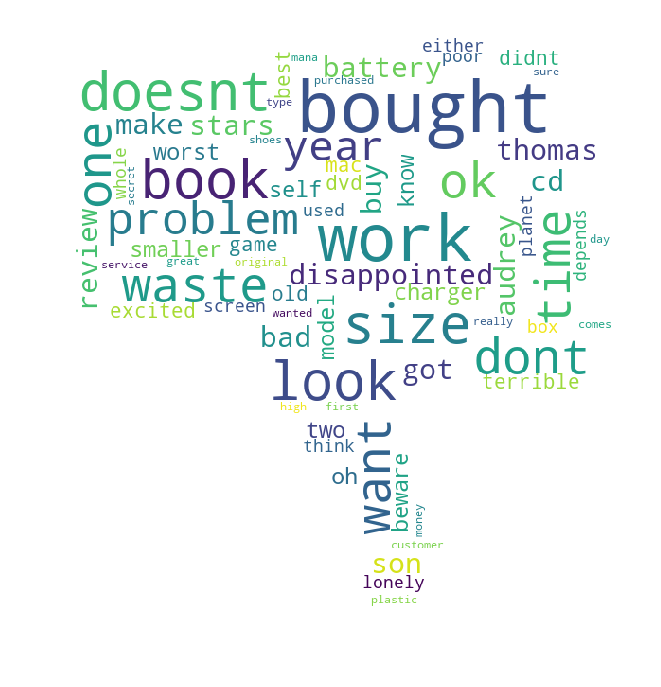

In [14]:
plot_wordcloud(df_train[df_train.label==0]['sentence'], mfsize=25, mask=down_mask)

<span style="color:red">**positve**</span> reviews

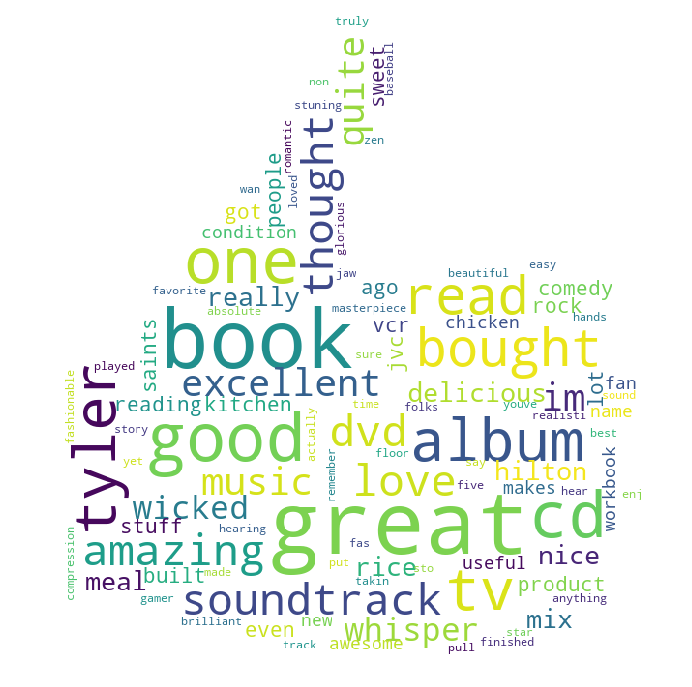

In [15]:
plot_wordcloud(df_train[df_train.label==1]['sentence'], mask=up_mask)

We can see a lot useful words to tell the two types apart, such as "<span style="color:red">great</span>", "<span style="color:red">good</span>", "<span style="color:red">amazing</span>", "<span style="color:red">excellent</span>", etc for <span style="color:red">positve</span> reviews; while "<span style="color:blue">waste</span>", "<span style="color:blue">problem</span>", "<span style="color:blue">disappointed</span>", "<span style="color:blue">bad</span>", etc for <span style="color:blue">negative</span> reviews.

In addition, some neutral words provide us information about what items are largely reviewed, such as "book", "cd", "dvd", "meal", "soundtrack", "tv", etc. 

Next let's see how well machine learning methods can do in the task of classifying their polarity.

## 3. Classification using *sklearn*<a id="3"></a>
First, define a couple of helper functions to plot confusion matrix and print important feature (word) coefficients.

In [16]:
# helper function to plot confusion matrix, copied from scikit-learn auto_examples
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

def print_fit_coef(tokenizer, clf):
    w = tokenizer.get_feature_names()
    coef = clf.coef_.tolist()[0]
    coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
    coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
    print('')
    print('-Top 10 positive-')
    print(coeff_df.head(10).to_string(index=False))
    print('')
    print('-Top 10 negative-')        
    print(coeff_df.tail(10).to_string(index=False))

### 3.1. Features: token counts<a id="3.1"></a>
We use CountVectorizer in *sklearn* to convert our text documents to a matrix of token counts. The output is a sparse representation of the counts using scipy.sparse.csr_matrix.

In [17]:
# ngram_range=(1,2): memory limit exceed :(
tokenizer = CountVectorizer(stop_words = 'english', max_features=10000)
X = tokenizer.fit_transform(train_sentences)
X_test = tokenizer.transform(test_sentences)

print('# n_features = {}'.format(X.shape[1]))
X_train, X_val, y_train, y_val = train_test_split(X, train_labels, random_state=0)
print('After splitting the Train dataset,')
print('# train size = {}'.format(X_train.shape[0]))
print('# validation size = {}'.format(X_val.shape[0]))
print('# unseen test size = {}'.format(X_test.shape[0]))

# n_features = 10000
After splitting the Train dataset,
# train size = 2700000
# validation size = 900000
# unseen test size = 400000


In order to save memory as well as only keep the most important words, max_features of 10000 is used.     
To perform the binary classification task, ML methods used are:
- Naive Bayes
- Logistic Regression

In addition, we will also try linear classifiers with SGD training (SGDClassifer).

#### 3.1.1. Naive Bayes
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [18]:
# since we don't tune any parameter here, let's use all the data to train.
start = time.time()
model = MultinomialNB().fit(X, train_labels)
print("NB took {} seconds to finish.".format(time.time() - start))
print("Training accuracy = ", model.score(X, train_labels))
print_fit_coef(tokenizer, model)

NB took 2.9378063678741455 seconds to finish.
Training accuracy =  0.8459052777777778

-Top 10 positive-
Word  Coefficient
  book    -3.992042
 great    -4.193134
  good    -4.516904
  like    -4.727796
  read    -4.908555
  love    -5.036796
  best    -5.145396
  time    -5.175729
really    -5.230117
 movie    -5.299650

-Top 10 negative-
Word  Coefficient
 uninspiring   -13.561445
 abomination   -13.590019
 uninstalled   -13.590019
     unfunny   -13.634471
unconvincing   -13.649738
        wast   -13.696991
         rma   -13.746588
      intuit   -13.816792
 paperweight   -14.017463
  restocking   -14.422928


**Analysis**

NB is superfast to fit.

Using NB, we obtained an accuracy of 84.59% for the training set. The best and worst coefficient words are somewhat reasonable, for example, "good", "great", "love", "like" for positive and "uninspiring", "unfunny", "abomination", "wast" for negative.

Next let's see its prediction power on unseen test dataset. Meanwhile, the confusion matrix will be plotted to show more metrics other than accuracy.

Accuracy for the unseen test set = 84.49%


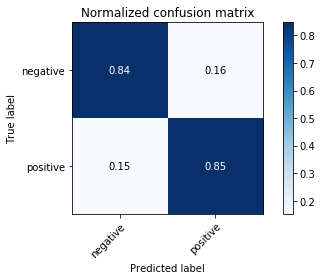

In [19]:
# for unseen test data
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, test_labels) * 100
print("Accuracy for the unseen test set = {0:.2f}%".format(precision))

# calculate the FPR and TPR for all thresholds of the classification
probs = model.predict_proba(X_test)
probs = probs[:, 1]
nb_fpr, nb_tpr, thresholds = metrics.roc_curve(test_labels, probs)
nb_auc = metrics.roc_auc_score(test_labels, probs)

cm , _ = plot_confusion_matrix(test_labels, y_pred, classes=np.array(['negative', 'positive']), normalize=True, title='Normalized confusion matrix')
plt.show()

The accuracy for the unseen test dataset is close to that in the trainning, 84.49%. Good that there is not much overfit. The distribution of the training and test dataset should be close enough. The precision and recall are close.

#### 3.1.2. LogisticRegression
We did a grid search on the hyperparameter C in logistic regression. The best C is chosen to be 5.

Running C = 0.01...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  training accuracy =  0.8936096296296296
  validation accuracy =  0.8927155555555556
Running C = 0.05...
  training accuracy =  0.8952174074074074
  validation accuracy =  0.8938433333333333
Running C = 0.1...
  training accuracy =  0.8954392592592593
  validation accuracy =  0.8939388888888888
Running C = 0.5...
  training accuracy =  0.8955711111111111
  validation accuracy =  0.8939611111111111
Running C = 1.0...
  training accuracy =  0.8955751851851852
  validation accuracy =  0.8939566666666666
Running C = 5.0...
  training accuracy =  0.8955962962962963
  validation accuracy =  0.8939733333333333
Running C = 10.0...
  training accuracy =  0.8955937037037037
  validation accuracy =  0.8939733333333333
Running C = 100.0...
  training accuracy =  0.89559
  validation accuracy =  0.89398


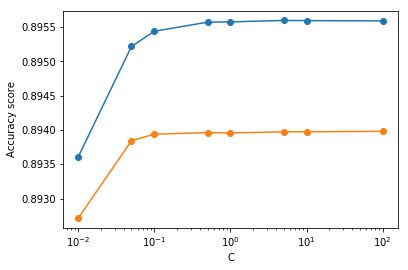

In [20]:
# do a grid search to optimize the hyperparameters
# for penalty in ['l1','l2']:   # not much change
accuracy = []
for C in [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]:  # smaller values specify stronger regularization
    print('Running C = {}...'.format(C))
    model = LogisticRegression(C=C, random_state=11).fit(X_train, y_train)
    acc_train = model.score(X_train, y_train)
    acc_val = model.score(X_val, y_val)
    print ('  training accuracy = ', acc_train)
    print ('  validation accuracy = ', acc_val)
    accuracy.append([C, acc_train, acc_val])
    
accuracy = np.array(accuracy)
plt.plot(accuracy[:,0], accuracy[:,1], marker='o', label='Training')
plt.plot(accuracy[:,0], accuracy[:,2], marker='o', label='Validation')
plt.xlabel('C')
plt.ylabel('Accuracy score')
plt.xscale('log')
plt.show()

In [21]:
start = time.time()
model = LogisticRegression(C=5.0, random_state=11).fit(X_train, y_train)
print("LogisticRegression took {} seconds to finish.".format(time.time() - start))
print_fit_coef(tokenizer, model)

LogisticRegression took 282.28711223602295 seconds to finish.

-Top 10 positive-
Word  Coefficient
   pleasantly     2.475616
    excelente     2.284493
indispensable     2.205770
   invaluable     2.122175
     exceeded     2.031984
   underrated     1.983270
   refreshing     1.857047
    excellant     1.830652
     excelent     1.805009
       awsome     1.787274

-Top 10 negative-
Word  Coefficient
   forgettable    -2.414057
  disapointing    -2.418109
   unimpressed    -2.432538
disappointment    -2.442318
  unlistenable    -2.483950
 dissapointing    -2.485581
 disappointing    -2.678781
   uninspiring    -2.742362
        emptor    -2.761491
          yawn    -2.847240


Accuracy for the unseen test set = 89.40%


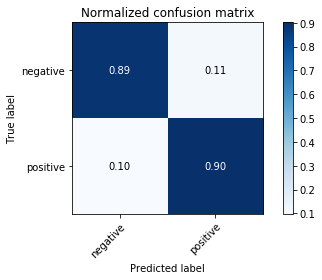

In [22]:
# for unseen test data
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, test_labels) * 100
print("Accuracy for the unseen test set = {0:.2f}%".format(precision))

# calculate the FPR and TPR for all thresholds of the classification
probs = model.predict_proba(X_test)
probs = probs[:, 1]
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(test_labels, probs)
lr_auc = metrics.roc_auc_score(test_labels, probs)

cm , _ = plot_confusion_matrix(test_labels, y_pred, classes=np.array(['negative', 'positive']), normalize=True, title='Normalized confusion matrix')
plt.show()

**Analysis**

The LogisticRegression takes longer time to train compared with NB. The best and worst coefficient words seem to be more reasonable this time, all being adjective, for example, "pleasantly", "invaluable", "excellent", "awsome" for positive and "uninspiring", "forgettable", "disappointing", "unimpressed" for negative. 

Using Logistic Regression, we got an accuracy of 89.40% for the unseen dataset. Much improved from NB. From the confusion matrix, we can also tell that the precision and recall are quite balanced.

**ROC Curve for NB and LG**

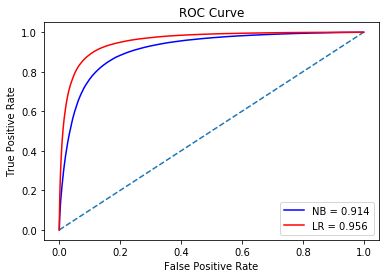

In [23]:
# plot ROC CURVE of all above methods
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(nb_fpr, nb_tpr, 'b', label = 'NB = %0.3f' % nb_auc )
plt.plot(lr_fpr, lr_tpr, 'r', label = 'LR = %.3f' % lr_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC curve provides us similar messages that logistic regression performs better than the naive bayes. With both AUC values larger than 0.9, we'd say the sklearn ML methods perform decently on our sentiment analysis.

####  3.1.3. SGDClassifer

In [24]:
start = time.time()
model = SGDClassifier().fit(X, train_labels)
print("SGDClassifier took {} seconds to finish.".format(time.time() - start))

print_fit_coef(tokenizer, model)

SGDClassifier took 22.9305362701416 seconds to finish.

-Top 10 positive-
Word  Coefficient
  excellent     1.013159
    awesome     1.001354
 pleasantly     0.970452
 refreshing     0.884692
     awsome     0.816291
outstanding     0.815249
    pleased     0.813166
  complaint     0.789903
    amazing     0.780876
  provoking     0.778792

-Top 10 negative-
Word  Coefficient
     worthless    -1.051700
       useless    -1.069407
         awful    -1.079476
        boring    -1.090934
      mediocre    -1.148571
         waste    -1.178431
        poorly    -1.201347
         worst    -1.278081
disappointment    -1.428423
 disappointing    -1.598208


Accuracy for the unseen test set = 89.24%


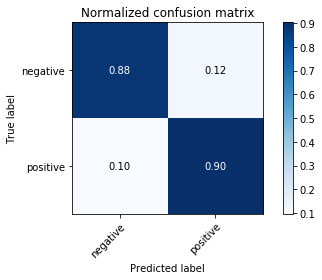

In [25]:
# for unseen test data
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, test_labels) * 100
print("Accuracy for the unseen test set = {0:.2f}%".format(precision))

cm , _ = plot_confusion_matrix(test_labels, y_pred, classes=np.array(['negative', 'positive']), normalize=True, title='Normalized confusion matrix')
plt.show()

SGDClassifer performs very closely to the LogisticRegression.

### 3.2. Features: tf-idf<a id="3.2"></a>
The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

To better compare, we will repeat the training using the same methods as part 3.1.

In [26]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)
X_test = tfidf_transformer.transform(X_test)

In [27]:
print('# n_features = {}'.format(X.shape[1]))

X_train, X_val, y_train, y_val = train_test_split(X, train_labels, random_state=0)
print('After splitting the Train dataset,')
print('# train size = {}'.format(X_train.shape[0]))
print('# validation size = {}'.format(X_val.shape[0]))
print('# unseen test size = {}'.format(X_test.shape[0]))

# n_features = 10000
After splitting the Train dataset,
# train size = 2700000
# validation size = 900000
# unseen test size = 400000


#### 3.2.1. Naive Bayes

In [28]:
# since we don't tune any parameter here, let's use all the data to train.
start = time.time()
model = MultinomialNB().fit(X, train_labels)
print("NB took {} seconds to finish.".format(time.time() - start))
print("Training accuracy = {0:.2f}%".format(model.score(X_test, test_labels)*100))
print_fit_coef(tokenizer, model)

NB took 1.851508617401123 seconds to finish.
Training accuracy = 84.33%

-Top 10 positive-
Word  Coefficient
  book    -4.744161
 great    -4.796399
  good    -5.147717
  love    -5.401629
  read    -5.414522
  like    -5.485550
  best    -5.548166
 movie    -5.605596
    cd    -5.725713
really    -5.750238

-Top 10 negative-
Word  Coefficient
        wast   -13.163338
 uninspiring   -13.212132
 abomination   -13.221197
     unfunny   -13.240989
 uninstalled   -13.248764
unconvincing   -13.272615
         rma   -13.336415
      intuit   -13.414152
 paperweight   -13.484696
  restocking   -13.786715


#### 3.2.2. Logistic Regression

In [29]:
start = time.time()
model = LogisticRegression(C=0.1, random_state=11).fit(X_train, y_train)
print("LogisticRegression took {} seconds to finish.".format(time.time() - start))
print_fit_coef(tokenizer, model)

# for unseen test data
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, test_labels) * 100
print("Accuracy for the unseen test set = {0:.2f}%".format(precision))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression took 104.3709659576416 seconds to finish.

-Top 10 positive-
Word  Coefficient
    great    11.896186
excellent    11.821269
  awesome     8.800151
  perfect     8.393320
     best     8.082102
   highly     7.834887
  amazing     7.786802
wonderful     7.298365
     love     6.885184
fantastic     6.574512

-Top 10 negative-
Word  Coefficient
      horrible    -9.291043
      terrible    -9.506421
        poorly    -9.782902
        boring   -10.243402
  disappointed   -10.544023
          poor   -10.643143
disappointment   -11.407051
         worst   -12.565956
         waste   -12.989479
 disappointing   -13.395570
Accuracy for the unseen test set = 89.23%


From the results, we can tell that two feature selections provide similar results.

## 4. Neural Networks<a id="4"></a>
Deep learning methods, such as CNN and RNN, are proving very good at text classification. Which deep NN type performs better when dealing with text data depends on how often the comprehension of global/long-range semantics is required. For tasks where length of text is important, for example question-answering, translation etc, it is prefered to go with RNN variants. In a lot of other cases, CNNs have also been proven to perform very well.

In this part, both CNN and RNN are tested on our task.

### 4.0. Text Tokenization and Word Embedding<a id="4.0"></a>

#### Text Tokenization
Before building NN, we will first use the keras tools to vectorize our text corpus by turning each text into a sequence of integers (each integer being the index of a token in a dictionary). The maximum number of features is set to be **5000 features** (while 10,000 is also tested and the results will be compared in the end).

Considering the reviews are usually not too long and their polarity can be recognized before finishing the whole content, we set the ***maxlen* to be 100** when padding sequences. 

In [12]:
max_features = 5000
maxlen = 100
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_sentences)

In [13]:
tokenized_train = tokenizer.texts_to_sequences(train_sentences)
X = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   20,  900,   49,  145,   28,   64,   83,  127,  711,
         20,   61,  900, 1394,  261,  396,  152, 3104,  141, 1998, 1373,
         38, 2681,   28,  456,   55, 1415,  300,   78, 3242,  129,   84,
         67,   90,   18,   24,   14,   36,    2,  126,    6,   74,   72,
       2409], dtype=int32)

In [15]:
tokenized_test = tokenizer.texts_to_sequences(test_sentences)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

Split the dataset into train and validation.

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, train_labels, test_size=0.1, random_state=0)
print('After splitting the Train dataset,')
print('# train size = {}'.format(X_train.shape[0]))
print('# validation size = {}'.format(X_val.shape[0]))

After splitting the Train dataset,
# train size = 3240000
# validation size = 360000


#### Word Embedding
In NLP, transfer learning has not been as successful as compared to computer vision. But we have pre-trained word embeddings like word2vec, GloVe, and fastText, which can be used to initialize the first layer of a neural network. Here we use a pre-trained 100-dimensional word embeddings of tweets from the [GloVe project at Stanford](https://nlp.stanford.edu/projects/glove/).

In [16]:
EMBEDDING_FILE = '../input/glovetwitter100d/glove.twitter.27B.100d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [17]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) #embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [18]:
del tokenized_test, tokenized_train, tokenizer, train_sentences, test_sentences, word_index, embeddings_index, all_embs, nb_words
gc.collect()

0

### 4.1. ConvNet 1D<a id="4.1"></a>

Let's define our CNN model. Whether the embedding layer parameters are trainable is changable. 

In [19]:
def cnn_model(train_embed=True):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=train_embed)(inp)    # use pretrained learning weights
    # x = Embedding(max_features, embed_size)(inp)   # initialize the embedding layer from scratch
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Conv1D(128, 7, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv1D(2, 1)(x)
    x = GlobalAveragePooling1D()(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs = inp, outputs = output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return model

#### 4.1.1. Fix the embedding layer

In [20]:
embed_size = 100
model = cnn_model(train_embed=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100)          400       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 128)          89728     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 128)          512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 128)          49280     
__________

In [22]:
weight_path="early_weights.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=7)
callbacks = [checkpoint, early_stopping]

In [24]:
batch_size = 1024
epochs = 50
start = time.time()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_val, y_val), callbacks=callbacks)
print("time used by CNN = {}".format(time.time() - start))

Train on 3240000 samples, validate on 360000 samples
Epoch 1/50
3240000/3240000 [==============================] - 189s 58us/step - loss: 0.2895 - binary_accuracy: 0.8773 - val_loss: 0.2563 - val_binary_accuracy: 0.8945

Epoch 00001: val_loss improved from inf to 0.25634, saving model to early_weights.hdf5
Epoch 2/50
2299904/3240000 [====================>.........] - ETA: 51s - loss: 0.2528 - binary_accuracy: 0.8957

The model stopped at epoch = 36. Both our training accuracy and validation accuracy are above 92%. Next, we will plot the evolution of the accuracy and loss as the function of epoch.

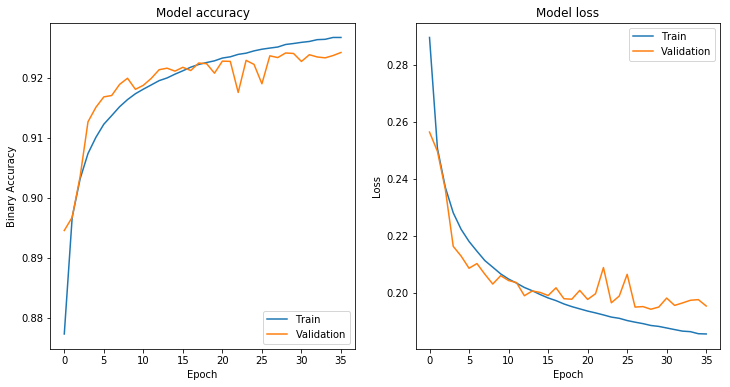

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
# Plot training & validation accuracy values
axs[0].plot(history.history['binary_accuracy'])
axs[0].plot(history.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Binary Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [26]:
model.load_weights(weight_path)
loss, acc = model.evaluate(X_test, test_labels, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

400000/400000 [==============================] - 7s 18us/step
Test loss: 0.19470330029010774
Test accuracy: 0.9239650000190734


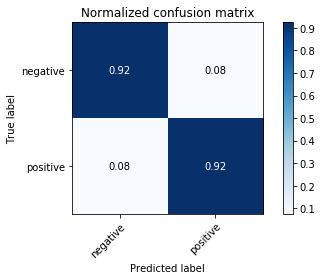

In [29]:
y_pred = cudnnlstm_model.predict(X_test, batch_size=batch_size)
y_classes = []
for v in y_pred:
    if v[0] > 0.5:
        y_classes.append(1)
    else:
        y_classes.append(0)
cm , _ = plot_confusion_matrix(test_labels, y_classes, classes=np.array(['negative', 'positive']), normalize=True, title='Normalized confusion matrix')
plt.show()

By applying our model on the unseen test dataset, we can see that the accuracy is about 92.40%. So,
- No overfitting in our model.
- A big improvement from using the NB or LG methods in *sklearn*.

***What if we allow the embedding layer to train?***
#### 4.1.2. Train the embedding layer

In [20]:
embed_size = 100
model = cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100)          400       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 128)          89728     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 128)          512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 128)          49280     
__________

More params to train. The training tiggered the earyly stopping after 16 epochs.

In [24]:
batch_size = 1024
epochs = 50
start = time.time()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_val, y_val), callbacks=callbacks)
print("time used by CNN = {}".format(time.time() - start))

Train on 3240000 samples, validate on 360000 samples
Epoch 1/50
3240000/3240000 [==============================] - 213s 66us/step - loss: 0.2405 - binary_accuracy: 0.9017 - val_loss: 0.2115 - val_binary_accuracy: 0.9163

Epoch 00001: val_loss improved from inf to 0.21147, saving model to early_weights.hdf5
Epoch 2/50
2298880/3240000 [====================>.........] - ETA: 58s - loss: 0.2065 - binary_accuracy: 0.9178

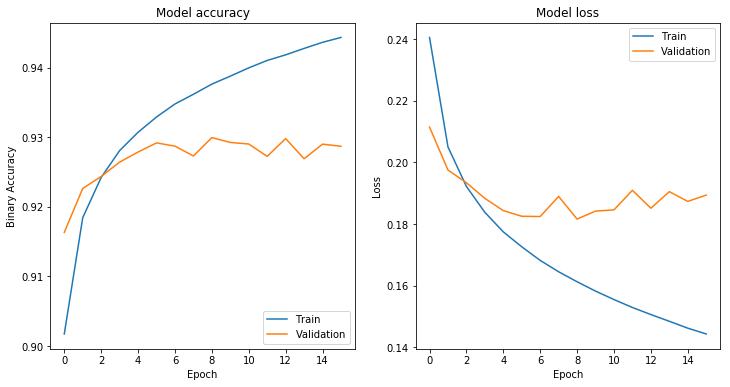

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
# Plot training & validation accuracy values
axs[0].plot(history.history['binary_accuracy'])
axs[0].plot(history.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Binary Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

We can see that the training accuracy becomes much better than the validation accuracy, indicating an **overfitting**.

In [26]:
model.load_weights(weight_path)
loss, acc = model.evaluate(X_test, test_labels, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

400000/400000 [==============================] - 7s 18us/step
Test loss: 0.18238257784366607
Test accuracy: 0.9296500000190735


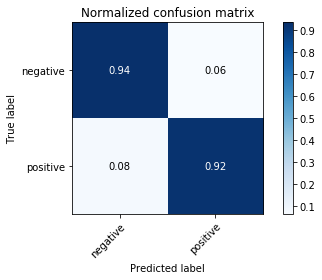

In [29]:
y_pred = cudnnlstm_model.predict(X_test, batch_size=batch_size)
y_classes = []
for v in y_pred:
    if v[0] > 0.5:
        y_classes.append(1)
    else:
        y_classes.append(0)
cm , _ = plot_confusion_matrix(test_labels, y_classes, classes=np.array(['negative', 'positive']), normalize=True, title='Normalized confusion matrix')
plt.show()

The performance on the unseen test dataset is slightly improved from our first try, reaching **92.97%** accuracy.

In addition, we also tried to use more features (10k) and the results are summarized later for comparisons.

### 4.2. RNN-LSTM<a id="4.2"></a>

Here we used [CuDNNLSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CuDNNLSTM), which is the FastLSTM implemented by cuDNN, so that we can utilize the GPU at Kaggle kernel.

Like what we tested in the CNN models, in this part, we will also test the cases when using 5000/10000 features and train/fix embedding layers. **This notebook only include the code cells for 5000 features.** 

In [19]:
def cudnnlstm_model(conv_layers = 2, max_dilation_rate = 3, train_embed=True):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=train_embed)(inp)
    x = Dropout(0.25)(x)
    x = Conv1D(2*embed_size, kernel_size = 3)(x)
    prefilt = Conv1D(2*embed_size, kernel_size = 3)(x)
    x = prefilt
    for strides in [1, 1, 2]:
        x = Conv1D(64*2**(strides), strides = strides, kernel_regularizer=l2(4e-6), bias_regularizer=l2(4e-6), kernel_size=3, kernel_constraint=maxnorm(10), bias_constraint=maxnorm(10))(x)
    # size control, 512 -> 
    x_f = CuDNNLSTM(128, kernel_regularizer=l2(4e-6), bias_regularizer=l2(4e-6), kernel_constraint=maxnorm(10), bias_constraint=maxnorm(10))(x)  
    x_b = CuDNNLSTM(128, kernel_regularizer=l2(4e-6), bias_regularizer=l2(4e-6), kernel_constraint=maxnorm(10), bias_constraint=maxnorm(10))(x)
    x = concatenate([x_f, x_b])
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

    return model

#### 4.2.1. Fix the embedding layer

In [20]:
embed_size = 100
cudnnlstm_model = cudnnlstm_model(train_embed=False)
cudnnlstm_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     500000      input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 200)      60200       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [22]:
weight_path="early_weights.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# early_stopping set to 5 epochs.
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [checkpoint, early_stopping]

In [24]:
batch_size = 2048
epochs = 50
start = time.time()
history = cudnnlstm_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                              validation_data=(X_val, y_val), callbacks=callbacks)
print("time used by CNN = {}".format(time.time() - start))

Train on 3240000 samples, validate on 360000 samples
Epoch 1/50
3240000/3240000 [==============================] - 242s 75us/step - loss: 0.3724 - binary_accuracy: 0.8356 - val_loss: 0.3095 - val_binary_accuracy: 0.8687

Epoch 00001: val_loss improved from inf to 0.30949, saving model to early_weights.hdf5
Epoch 2/50
3240000/3240000 [==============================] - 237s 73us/step - loss: 0.3312 - binary_accuracy: 0.8584 - val_loss: 0.3106 - val_binary_accuracy: 0.8690

Epoch 00002: val_loss did not improve from 0.30949
Epoch 3/50
3240000/3240000 [==============================] - 237s 73us/step - loss: 0.3223 - binary_accuracy: 0.8629 - val_loss: 0.3256 - val_binary_accuracy: 0.8634

Epoch 00003: val_loss did not improve from 0.30949
Epoch 4/50
1351680/3240000 [===========>..................] - ETA: 2:13 - loss: 0.3184 - binary_accuracy: 0.8651

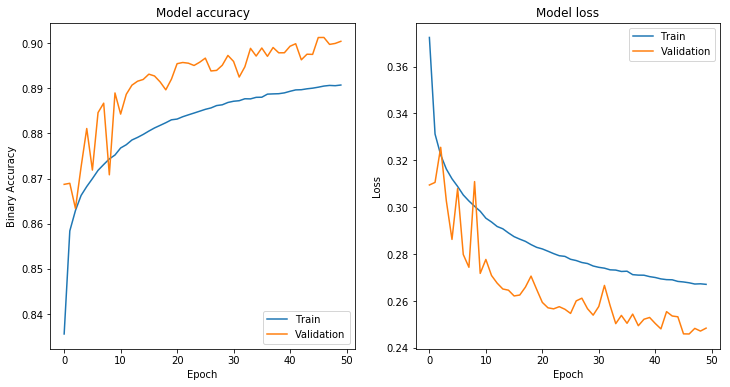

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
# Plot training & validation accuracy values
axs[0].plot(history.history['binary_accuracy'])
axs[0].plot(history.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Binary Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

**Note**: this model seems not overfitted. More epochs can be run. But not much improvement is gained.

In [26]:
cudnnlstm_model.load_weights(weight_path)
loss, acc = cudnnlstm_model.evaluate(X_test, test_labels, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

400000/400000 [==============================] - 9s 23us/step
Test loss: 0.24603214233875276
Test accuracy: 0.900955000038147


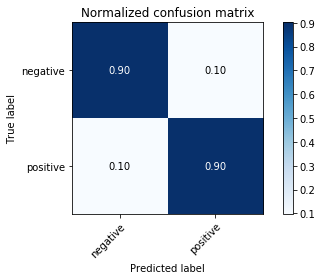

In [29]:
y_pred = cudnnlstm_model.predict(X_test, batch_size=batch_size)
y_classes = []
for v in y_pred:
    if v[0] > 0.5:
        y_classes.append(1)
    else:
        y_classes.append(0)
cm , _ = plot_confusion_matrix(test_labels, y_classes, classes=np.array(['negative', 'positive']), normalize=True, title='Normalized confusion matrix')
plt.show()

The accuracy in this case is about 90%, which is close to, but as good as CNN.

Next, let's train the embedding layer.
#### 4.2.2. Train the embedding layer

In [20]:
embed_size = 100
cudnnlstm_model = cudnnlstm_model(train_embed=True)
cudnnlstm_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     500000      input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 200)      60200       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [24]:
batch_size = 2048
epochs = 40
start = time.time()
history = cudnnlstm_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                              validation_data=(X_val, y_val), callbacks=callbacks)
print("time used by CNN = {}".format(time.time() - start))

Train on 3240000 samples, validate on 360000 samples
Epoch 1/40
3240000/3240000 [==============================] - 263s 81us/step - loss: 0.2854 - binary_accuracy: 0.8815 - val_loss: 0.2447 - val_binary_accuracy: 0.9004

Epoch 00001: val_loss improved from inf to 0.24469, saving model to early_weights.hdf5
Epoch 2/40
3240000/3240000 [==============================] - 257s 79us/step - loss: 0.2455 - binary_accuracy: 0.9016 - val_loss: 0.2296 - val_binary_accuracy: 0.9088

Epoch 00002: val_loss improved from 0.24469 to 0.22961, saving model to early_weights.hdf5
Epoch 3/40
3240000/3240000 [==============================] - 258s 79us/step - loss: 0.2348 - binary_accuracy: 0.9064 - val_loss: 0.2212 - val_binary_accuracy: 0.9121

Epoch 00003: val_loss improved from 0.22961 to 0.22122, saving model to early_weights.hdf5
Epoch 4/40
1351680/3240000 [===========>..................] - ETA: 2:24 - loss: 0.2296 - binary_accuracy: 0.9087

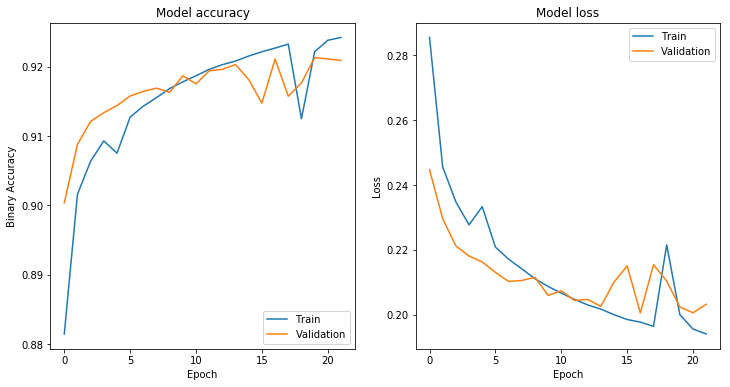

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
# Plot training & validation accuracy values
axs[0].plot(history.history['binary_accuracy'])
axs[0].plot(history.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Binary Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [26]:
cudnnlstm_model.load_weights(weight_path)
loss, acc = cudnnlstm_model.evaluate(X_test, test_labels, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

400000/400000 [==============================] - 9s 23us/step
Test loss: 0.20090069613933564
Test accuracy: 0.921042500038147


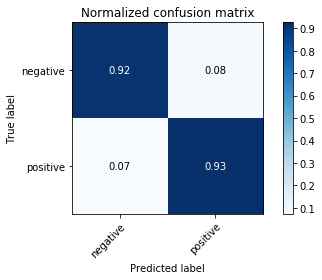

In [29]:
y_pred = cudnnlstm_model.predict(X_test, batch_size=batch_size)
y_classes = []
for v in y_pred:
    if v[0] > 0.5:
        y_classes.append(1)
    else:
        y_classes.append(0)
cm , _ = plot_confusion_matrix(test_labels, y_classes, classes=np.array(['negative', 'positive']), normalize=True, title='Normalized confusion matrix')
plt.show()

With the embedding layer allowed to be trained, the accuracy again improved from 90% to 92.1%.

**Comparison**

Based on the performance of CNN and RNN shown above, we see that,
- Although having less trainable parameters, the CNN performs better than RNN
- Although having more trainable parameters, the RNN mode doesn't reach the overfitting region.

The reason that CNN seems to outperform RNN in this task is that the long range semantics is not so important. Being able to identify the key words (plus nearby content) can do the prediction rather good.

**Note** at the end: A even larger RNN model was also tried with more than 7M parameters, and the accuracy further improved to about 94%. But the model starts to overfit with training accuracy much higher than the validation accuracy.

## 5. Conclusions<a id="5"></a>

In this work, we performed sentiment analysis on Amazon reviews. 

First, a summary of the model performance is listed in the following tables:

***sklearn***

| Method  | Feature  |  Accuracy (%) |
| ------------- |:-------------:|:-------------:|
| Naive Bayes |  Token Count  |   84.49    |  
| Naive Bayes |  TF-IDF       |   84.33    |
| Logistic Regression |   Token Count |  89.40  |
| Logistic Regression |   TF-IDF      |  89.23  |


***Neural Networks***

| Model    | # of features | Embedding trainable  | Total trainable parameters   |     Accuracy (%)  |
| ------------- |:-------------:|:-------------:|:-------------:|:-------------:|
| CNN      | 5000          | No       |  239,053   |   92.40    |
| CNN      | 5000          | Yes      |  739,053   |   92.97    |
| CNN      | 10000         | No       |  239,053   |   92.70    |
| CNN      | 10000         | Yes      | 1,032,269  | **94.49**  |
|  -       |    -          |  -       |     -      |      -     |
| RNN      | 5000          | No       |   816,945  |   90.10    |
| RNN      | 5000          | Yes      | 1,316,945  |   92.10    |
| RNN      | 10000         | No       |   816,945  |   90.47    |
| RNN      | 10000         | Yes      | 1,816,945  |   92.50    |
| RNN      | 20000         | Yes      | 7,193,009  | **93.97**  |

We learnt that,
- Traditional methods, such as Naive Bayes or logistic regression, perform decently on this task with accuracy between 80 and 90%. The advantage of those methods is the speed (seconds to finish), in particular the naive bayes method needs less than 10 seconds to run. Also, the results from them are easy to interpret. We are able to find out which words play important roles in separating positve and negative reviews.


- Neural networks perform much better than traditional methods.


- In this particular task, CNN is shown to outperform RNN.


- For the neural network models, care needs to be taken to prevent overfitting.